<a href="https://colab.research.google.com/github/asiftandel96/DS-Use-Cases/blob/main/eda_sa_and_hotel_booking_cancellation_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/sample_data/hotel_bookings.csv')
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [3]:
df['adults'].fillna(0, inplace = True)
df['children'].fillna(0, inplace = True)
df['babies'].fillna(0, inplace = True)

df['children'] = df['children'].astype(int)

In [4]:
df.shape

(119390, 32)

## Exploratory Data Analysis and SA

#### Distribution of the hotel based on the booking status

[Text(0.5, 1.0, 'Distribution of the hotel based on the booking status')]

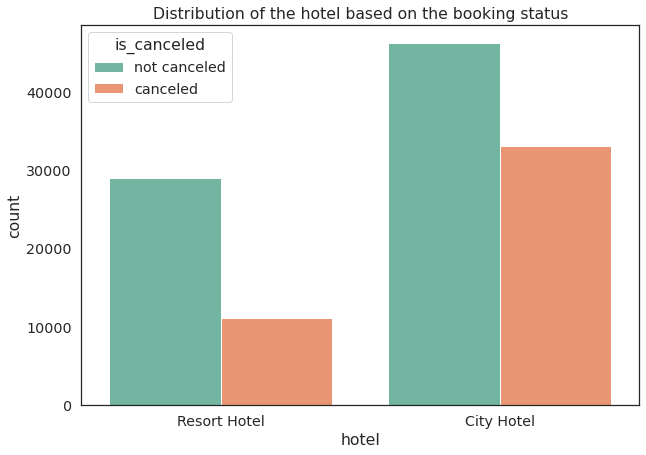

In [5]:
# Parameters
plt.rcParams['figure.figsize'] = [10, 7]
sns.set(style = 'white', font_scale = 1.3)

#1: canceled and 0: not canceled
df['is_canceled'].replace({1: 'canceled', 0: 'not canceled'}, inplace = True)

# Plot
dist = sns.countplot(df['hotel'], hue = 'is_canceled', data = df, palette = 'Set2')

dist.set(title = "Distribution of the hotel based on the booking status")

The number of cancellation in City Hotel is twice as compared
to Resort Hotel

#### Number of Reservations per year (months)

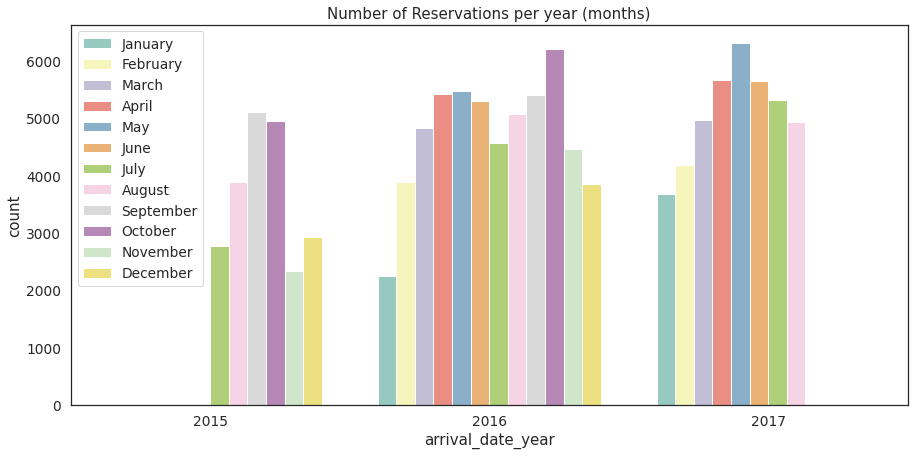

In [6]:
# parameters
plt.rcParams['figure.figsize'] = [15, 7]
sns.set(style = 'white', font_scale = 1.25)

# plot
arrival = sns.countplot(df['arrival_date_year'], hue = 'arrival_date_month', data = df, palette = 'Set3',
             hue_order = ['January', 'February', 'March', 'April', 'May', 'June',
                          'July', 'August', 'September', 'October', 'November', 'December'])
arrival.set(title = "Number of Reservations per year (months)")
plt.legend(loc='upper left')

#### Reservation Status per year

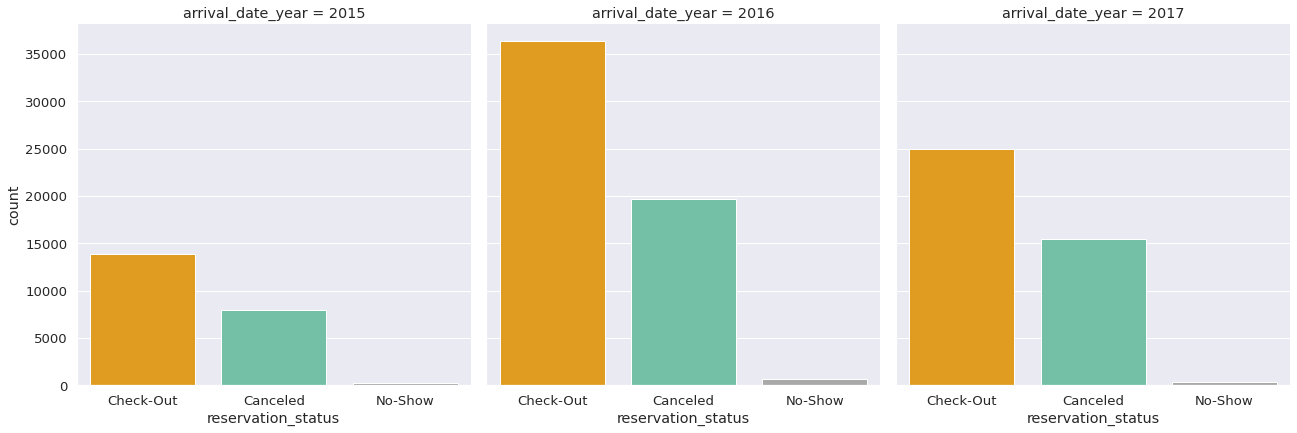

In [7]:
# Parameters
plt.rcParams['figure.figsize'] = [15, 7]
sns.set(style = 'darkgrid', font_scale = 1.2)

# catplot (countplot)
cat = sns.catplot(x = 'reservation_status', col = 'arrival_date_year', kind = 'count', data = df,
            height = 6, palette = ['orange', 'mediumaquamarine', 'darkgrey'])

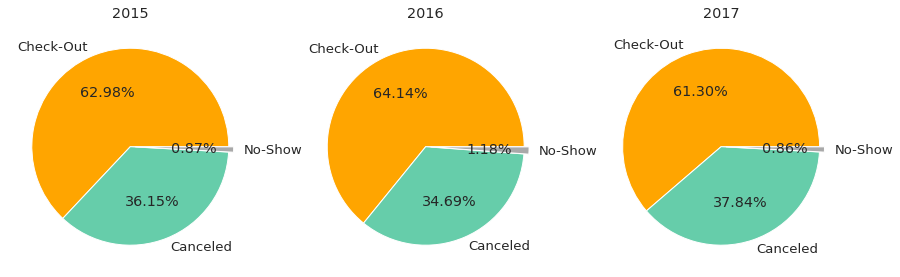

In [8]:
fig, ax = plt.subplots(1, 3)
sns.set(font_scale = 1.2)

val_2015 = df['reservation_status'].groupby(df['arrival_date_year']).value_counts()[2015].values
val_2016 = df['reservation_status'].groupby(df['arrival_date_year']).value_counts()[2016].values
val_2017 = df['reservation_status'].groupby(df['arrival_date_year']).value_counts()[2017].values
index = list(df['reservation_status'].groupby(df['arrival_date_year']).value_counts()[2015].index)

color = ['orange', 'mediumaquamarine', 'darkgrey']

# 2015
ax[0].pie(val_2015, labels = index, autopct='%.02f%%', explode = [0, 0, 0.05], colors = color)
ax[0].set_title('2015')

# 2016
ax[1].pie(val_2016, labels = index, autopct='%.02f%%', explode = [0, 0, 0.05], colors = color)
ax[1].set_title('2016')

# 2017
ax[2].pie(val_2017, labels = index, autopct='%.02f%%', explode = [0, 0, 0.05], colors = color);
ax[2].set_title('2017')
plt.show()

#### Donut Graph showing the canceled and non canceled booking each year

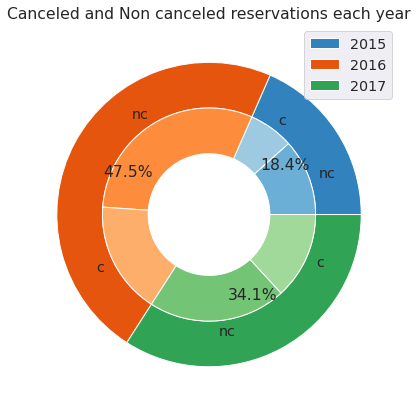

In [9]:
# Donut Graph showing the canceled and non canceled reservations each year
val_2015 = df['is_canceled'].groupby(df['arrival_date_year']).value_counts()[2015].values
val_2016 = df['is_canceled'].groupby(df['arrival_date_year']).value_counts()[2016].values
val_2017 = df['is_canceled'].groupby(df['arrival_date_year']).value_counts()[2017].values

t = np.array([val_2015, val_2016, val_2017])

fig, ax = plt.subplots()
sns.set(font_scale = 1.3)
size = 0.3 

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

ax.pie(t.sum(axis = 1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), autopct='%.01f%%')

ax.pie(t.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels = ['nc', 'c', 'nc', 'c', 'nc', 'c'])

ax.set(aspect="equal", title='Canceled and Non canceled reservations each year')
ax.legend([2015, 2016, 2017], loc = 'best')

#### Canceled and Non Canceled Booking according to the Dates

In [10]:
# Concatenation of arrivale date from year, month and day
df['arrival_date_month_num'] = df['arrival_date_month'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)

df_1 = pd.DataFrame()

# converting to datetime
df_1[['year', 'month', 'day']] = df[["arrival_date_year", "arrival_date_month_num", "arrival_date_day_of_month"]].copy()
df['arrival_date'] = pd.to_datetime(df_1[['year', 'month', 'day']])

# Sorting the dataframe by arrival dates
df.sort_values(by = ['arrival_date'], inplace = True)
del df_1

df['arrival_date'][0:10]

0       2015-07-01
75559   2015-07-01
75560   2015-07-01
75561   2015-07-01
75562   2015-07-01
75563   2015-07-01
75564   2015-07-01
75565   2015-07-01
75566   2015-07-01
75558   2015-07-01
Name: arrival_date, dtype: datetime64[ns]

In [11]:
# Grouping the arrival dates and counting the canceled and not canceled reservations
df.replace({'not canceled' : -1, 'canceled' : 1}, inplace = True)
a = df[['is_canceled', 'arrival_date']].groupby(df['arrival_date'])['is_canceled'].value_counts()

# timestamps
b = [a.index[x][0] for x in range(len(a))]

# canceled or not canceled array
c = [a.index[x][1] for x in range(len(a))]

# 1 represents the canceled and -1 represents not canceled
g = a.values * c # below zero axis it will be not canceled and above it will be canceled


fig = px.bar(x = b, y = g, title = 'Canceled and Non Canceled Reservation according to the Dates',
            color = g,
            labels = {
                     "x": "Date",
                     "y": "Reservations (c or nc)",
                 })
fig.show()

#### Hotel Choices for Adults without children, Adults with children and Only Children

In [12]:
# These are the datapoints where there is no adults, children and babies so we will not consider these points

_ = df[(df.children ==0)&(df.babies ==0)&(df.adults == 0)].shape
print ("Data Points without any adults, children and babies : ", _)

# Dropping those data points
df_1 = df[(df.children !=0) | (df.babies !=0) | (df.adults != 0)]

only_adults = df_1[(df_1.children ==0)&(df_1.babies ==0)]
adults_w_child = df_1[(df_1.children !=0) | (df_1.babies !=0)]
only_childs = df_1[df_1.adults == 0]

print ("Only Adults : ", only_adults.shape[0])
print ("Adults with children : ", adults_w_child.shape[0])
print ("Only children and babies : ", only_childs.shape[0])

Data Points without any adults, children and babies :  (180, 34)
Only Adults :  109878
Adults with children :  9332
Only children and babies :  223


In [13]:
# Hotels
hotel = ['City Hotel', 'Resort Hotel']

fig = go.Figure()

# Adults w/o children
fig.add_trace(go.Bar(
    x = hotel,
    y = only_adults['hotel'].value_counts().tolist(),
    name='Adults w/o children',
    marker_color='indianred'
))

# Adults w/ children
fig.add_trace(go.Bar(
    x = hotel,
    y = adults_w_child['hotel'].value_counts().tolist(),
    name='Adults w/ children',
    marker_color='lightsalmon'
))

# Only children
fig.add_trace(go.Bar(
    x = hotel,
    y = only_childs['hotel'].value_counts().tolist(),
    name='Only children'
))

# Here we modify the layout of the figure
fig.update_layout(
    barmode='group',
    xaxis_tickangle=0,
    autosize=False,
    width = 750,
    height = 900
)
fig.show()

#### Total Number of guest from different countries whose bookings are not canceled

In [14]:
# total people who booked from the countries
df['total_guest'] = df['adults'] + df['children'] + df['babies']

# non canceled bookings
df.replace({-1 : 0, 1 : 1}, inplace = True)
df1 = df.loc[df.is_canceled == 0, :].copy()

countries = pd.DataFrame(df1[['total_guest', 'country']].groupby(df1['country'])['total_guest'].sum())

print ("Total Countries in the dataset : ", df['country'].nunique())

# piechart
fig = px.pie(countries, values = 'total_guest', names = countries.index, title = 'Total Number of guest from different countries whose bookings are not canceled')
fig.update_traces(textposition='inside')
#fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show()

Total Countries in the dataset :  177


#### Total Number of Guests from Different Countries on World Map

In [15]:
# show on map
world_map = px.choropleth(countries,
                    locations = countries.index,
                    color = 'total_guest', 
                    hover_name = countries.index, 
                    color_continuous_scale = px.colors.sequential.Sunsetdark,
                    title = "Total Number of Guests from Different Countries on World Map")

#world_map.update_geos(fitbounds = "locations", visible = False)
# world_map.update_layout(margin = {"r":0,"t":0,"l":0,"b":0})

world_map.show()

#### Total Number of Hotel Guests per month

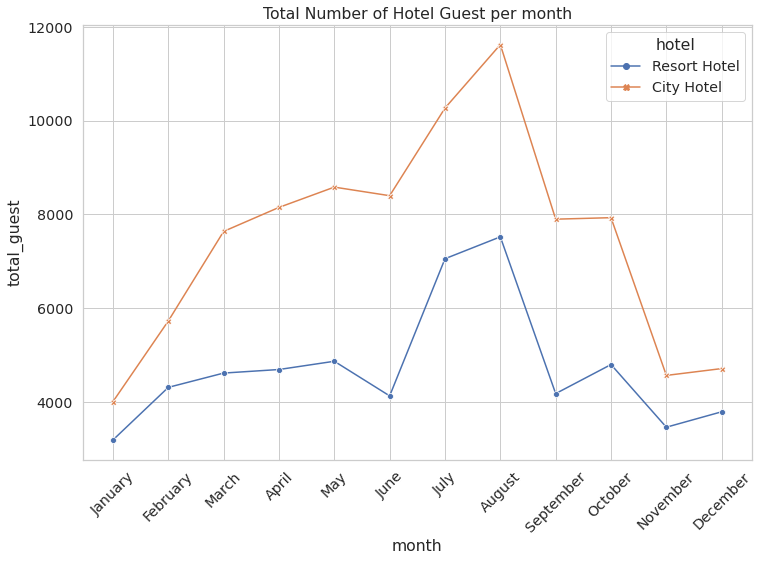

In [16]:
# Non Canceled bookings
df_1 = df.loc[df.is_canceled == 0, :].copy()

# Total Guest for Resort Hotel
a = df_1.loc[df.hotel == 'Resort Hotel', :]

b = a[['arrival_date_month', 'total_guest']].groupby(a['arrival_date_month']).sum()
b['hotel'] = ['Resort Hotel']*len(b)
c = b.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

# Total guest for City Hotel
a1 = df_1.loc[df.hotel == 'City Hotel', :]

b1 = a1[['arrival_date_month', 'total_guest']].groupby(a1['arrival_date_month']).sum()
b1['hotel'] = ['City Hotel']*len(b1)
c1 = b1.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

hot = pd.concat([c, c1])
hot['month'] = hot.index

plt.rcParams['figure.figsize'] = [12, 8]
sns.set(style = 'whitegrid', font_scale = 1.3)
ax = sns.lineplot(x = 'month', y="total_guest", data=hot, hue = 'hotel', sort = False, style = 'hotel', markers=True, dashes = False)
ax.set(title = "Total Number of Hotel Guest per month")
plt.setp(ax.get_xticklabels(), rotation = 45);

We can see the maximum number of hotel guests are there in August followed by July for both types of hotel. This can occur also because the data given for August and July span over 3 years and for all the other months the data is from 2 years. This discrepancy can be corrected if we take the average number of guests. The minimum number of guest is in January.

#### Average number of guest per month  (Busiest Month over the years)

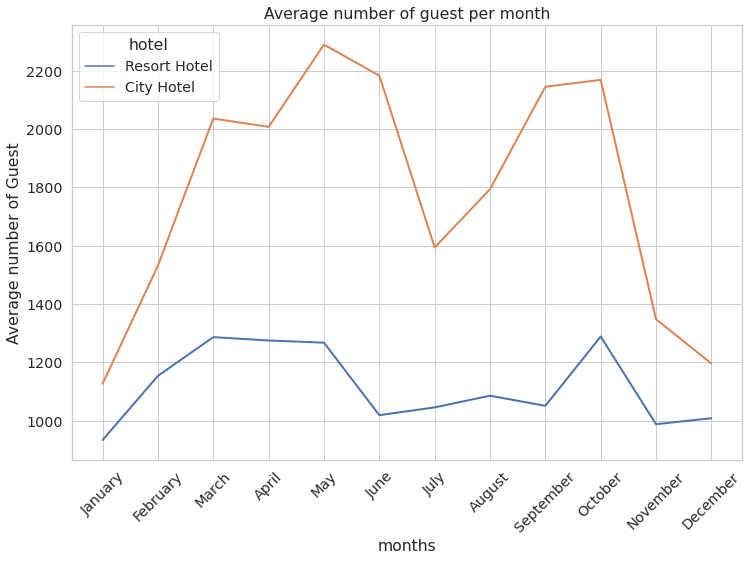

In [17]:
# preproc
df_1 = df.loc[df.is_canceled == 0, :].copy()
a = df_1[['hotel', 'arrival_date_month']].copy()

rh = pd.DataFrame(a.loc[a.hotel == 'Resort Hotel', 'arrival_date_month'].value_counts())
rh['hotel'] = ['Resort Hotel']*len(rh)
rh = rh.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

ch = pd.DataFrame(a.loc[a.hotel == 'City Hotel', 'arrival_date_month'].value_counts())
ch['hotel'] = ['City Hotel']*len(ch)
ch = ch.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

fin = pd.concat([rh, ch])
fin['months'] = fin.index

# Finding the average number of guest per month over the year the data is available
def average(x, y):
    if y not in ['July', 'August']:
        return x/2
    else:
        return x/3

fin['avg'] = fin.apply(lambda x: average(x.arrival_date_month, x.months), axis = 1)

ax1 = sns.lineplot(fin['months'], fin['avg'], hue = 'hotel', data = fin, sort = False, lw = 2)
ax1.set(title = "Average number of guest per month", ylabel = "Average number of Guest")
plt.setp(ax1.get_xticklabels(), rotation = 45);

#### Rooms Assigned to the Guests according to their reservation and the Reservation Status of the guest who are assigned different rooms

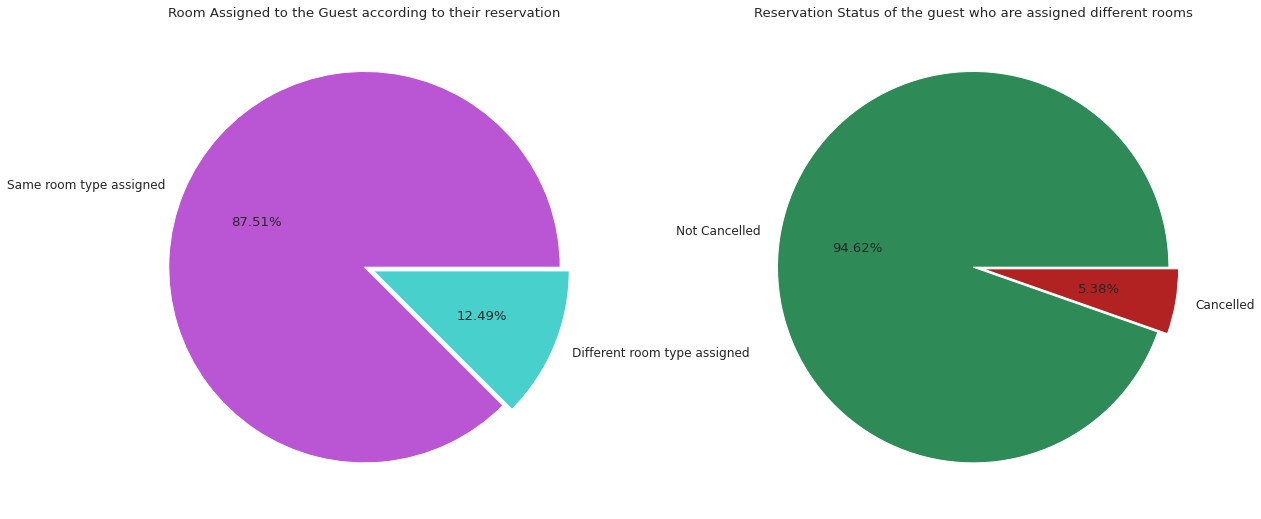

In [18]:
# Parameters
plt.rcParams['figure.figsize'] = [20, 9]
fig, ax = plt.subplots(1, 2)
sns.set(font_scale = 1.1)

r = df[['is_canceled', 'reserved_room_type', 'assigned_room_type']].copy()

def samediff(x, y):
    if x == y:
        return ("Same")
    else:
        return ("Diff")
    
r['assignment'] = r.apply(lambda x : samediff(x.reserved_room_type, x.assigned_room_type), axis = 1)

len(r.loc[r.assignment == 'Diff', :]['is_canceled'])
cnc = r.loc[r.assignment == 'Diff', :]['is_canceled'].value_counts()

r = r['assignment'].value_counts()

# pie chart for the assigned room type
ax[0].pie(r.values, labels = ['Same room type assigned', 'Different room type assigned'],
        autopct='%.02f%%', explode = [0, 0.05], colors = ['mediumorchid', 'mediumturquoise']);
ax[0].set_title('Room Assigned to the Guest according to their reservation');

# pie chart for the reservations status who are assigned different rooms
ax[1].pie(cnc.values, labels = ['Not Cancelled', 'Cancelled'],
        autopct='%.02f%%', explode = [0, 0.05], colors = ['seagreen', 'firebrick']);
ax[1].set_title('Reservation Status of the guest who are assigned different rooms');

#### Average Daily Rate of the Both Type of Hotels

ADR - The average daily rate is calculated by taking the average revenue earned from rooms and dividing it by the number of rooms sold. It excludes complimentary rooms and rooms occupied by staff.

In [19]:
# Removing the ghost values
df = df.loc[(df.children != 0)|(df.babies != 0)|(df.adults != 0), :]

# Rate per person
df['adr_per_person'] = df['adr']/(df['adults'] + df['children'])

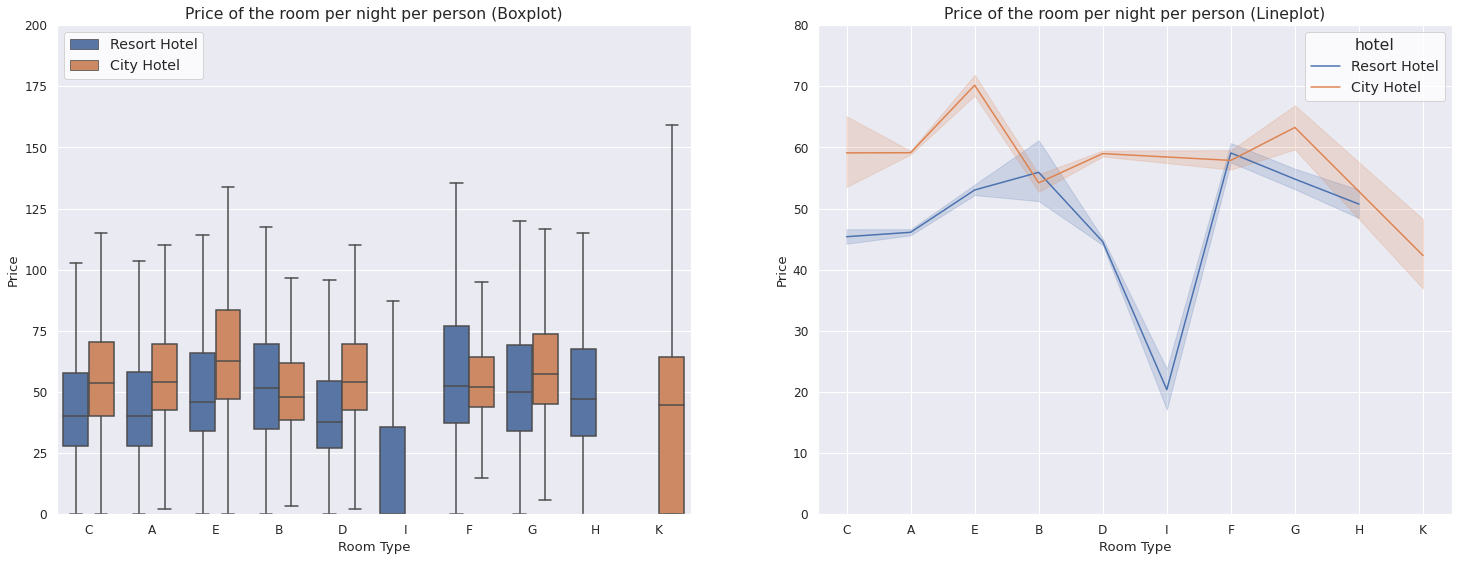

In [20]:
# Parameters
plt.rcParams['figure.figsize'] = [25, 9]
fig, ax = plt.subplots(1, 2)
sns.set(style = 'whitegrid', font_scale = 1.3)

nc = df.loc[df.is_canceled == 0, :].copy()
rh = nc.loc[nc.hotel == 'Resort Hotel', ['adr_per_person', 'assigned_room_type', 'hotel']]
ch = nc.loc[nc.hotel == 'City Hotel', ['adr_per_person', 'assigned_room_type', 'hotel']]

# Final df
fin = pd.concat([rh, ch], ignore_index = True)

# Boxplot Showing the 5 number summaries of the room price per person per night for the different room
box = sns.boxplot(y = fin.adr_per_person, data = fin, x = fin.assigned_room_type, hue = 'hotel', fliersize=0, ax = ax[0])
box.set(title = 'Price of the room per night per person (Boxplot)', xlabel = 'Room Type', ylabel = 'Price', ylim = (0, 200))
box.legend(loc='upper left');

# lineplot showing the variation of the room price per person per night with 95% confidence interval
line = sns.lineplot(y = fin.adr_per_person, data = fin, x = fin.assigned_room_type, hue = 'hotel', ci = 95, ax = ax[1])
line.set(title = 'Price of the room per night per person (Lineplot)', xlabel = 'Room Type', ylabel = 'Price', ylim = (0, 80));

In [21]:
resort_mean = nc.loc[(nc.is_canceled == 0) & (nc.hotel == 'Resort Hotel'), 'adr_per_person'].mean()
city_mean = nc.loc[(nc.is_canceled == 0) & (nc.hotel == 'City Hotel'), 'adr_per_person'].mean()

print ("The mean price of the rooms per night per person for Resort Hotel is {:.2f}".format(resort_mean))
print ("The mean price of the rooms per night per person for City Hotel is {:.2f}".format(city_mean))

The mean price of the rooms per night per person for Resort Hotel is 47.49
The mean price of the rooms per night per person for City Hotel is 59.27


#### Reservation status of the Guests with and without special requests

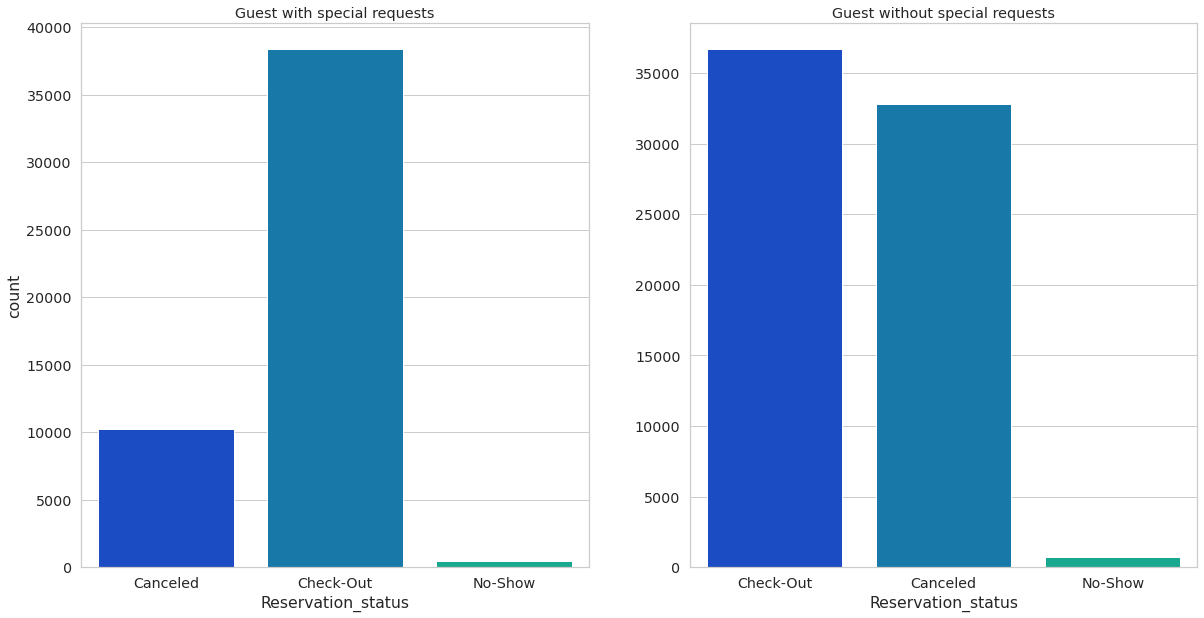

In [22]:
# Parameters
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(1, 2)
sns.set(style = 'darkgrid', font_scale = 1.2)

# Special and non Special Request of the guest
special_req = df[df.total_of_special_requests != 0].copy()
non_special_req = df[df.total_of_special_requests == 0].copy()

# Plots
spec = sns.countplot(special_req.reservation_status, ax = ax[0], palette = 'winter')
spec.set(title = 'Guest with special requests', xlabel = 'Reservation_status')

n_spec = sns.countplot(non_special_req.reservation_status, ax = ax[1], palette = 'winter')
n_spec.set(title = 'Guest without special requests', ylabel = "", xlabel = 'Reservation_status');

#### Average Number of Special request over the months [95% ci]

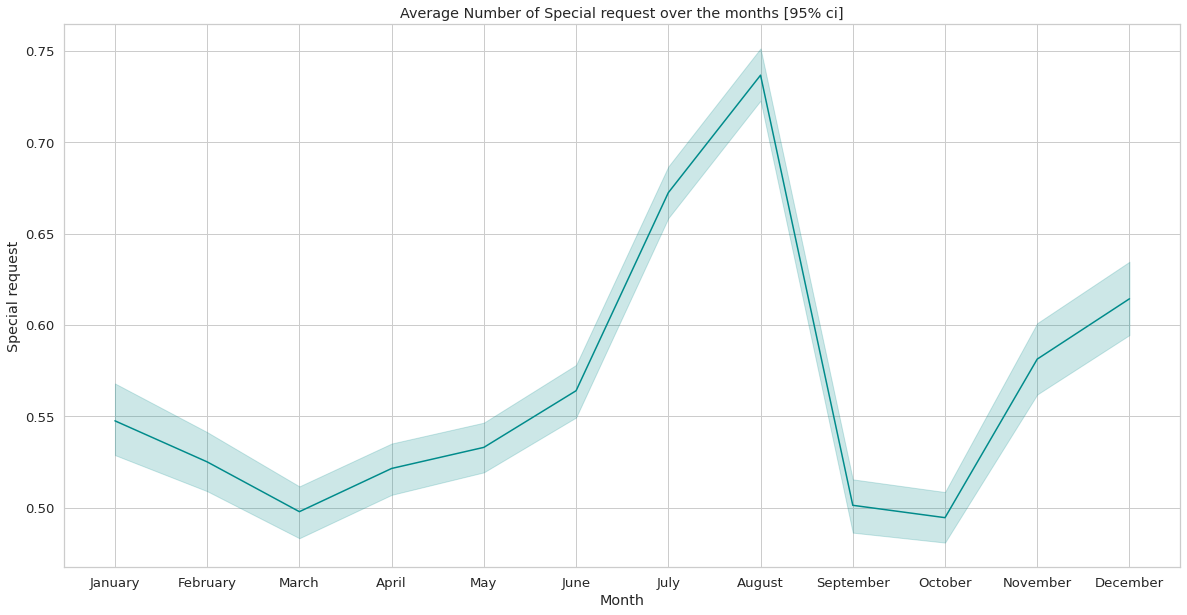

In [23]:
sns.set(style = 'whitegrid', font_scale = 1.2)

a = sns.lineplot(y = df.total_of_special_requests, x = df.arrival_date_month_num, data = df, color = 'darkcyan')
plt.xticks(np.arange(1, 13, 1))
a.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

a.set(title = 'Average Number of Special request over the months [95% ci]', xlabel = 'Month', ylabel = 'Special request');

#### Spearman and Pearson correlation heatmap

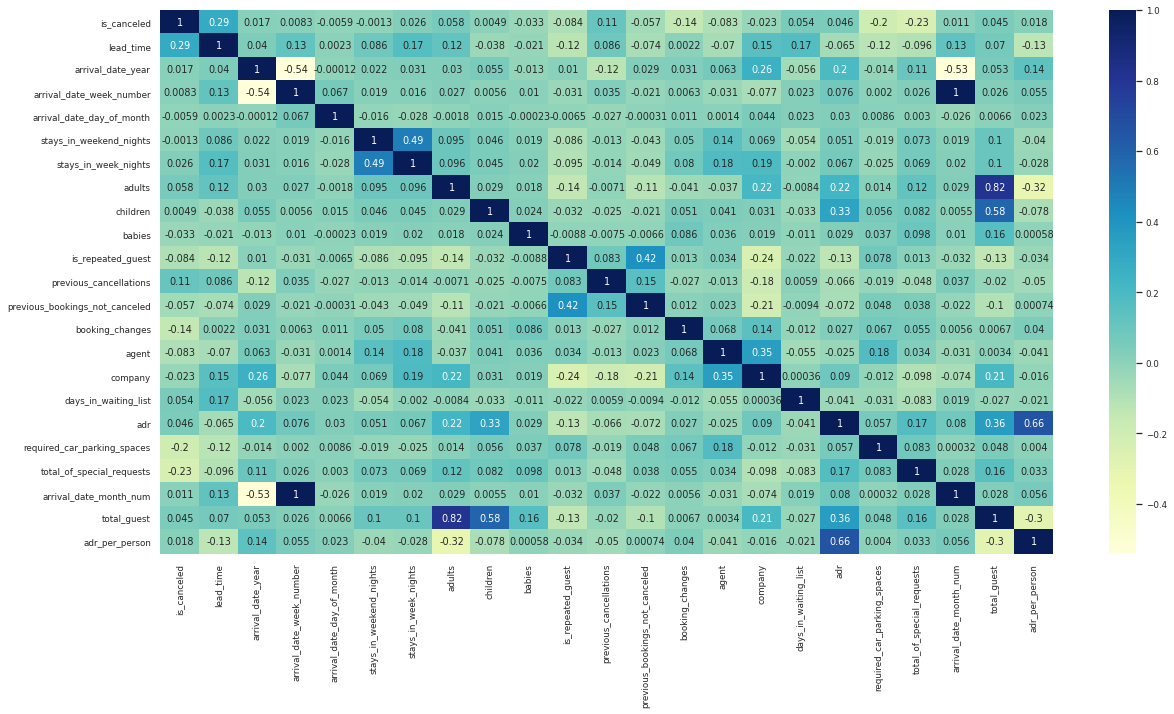

In [24]:
# Pearson Correlation Heatmap
plt.rcParams['figure.figsize'] == [18, 16]
sns.set(font_scale = 0.8)

sns.heatmap(df.corr(method = 'pearson'), annot = True, cmap = "YlGnBu")

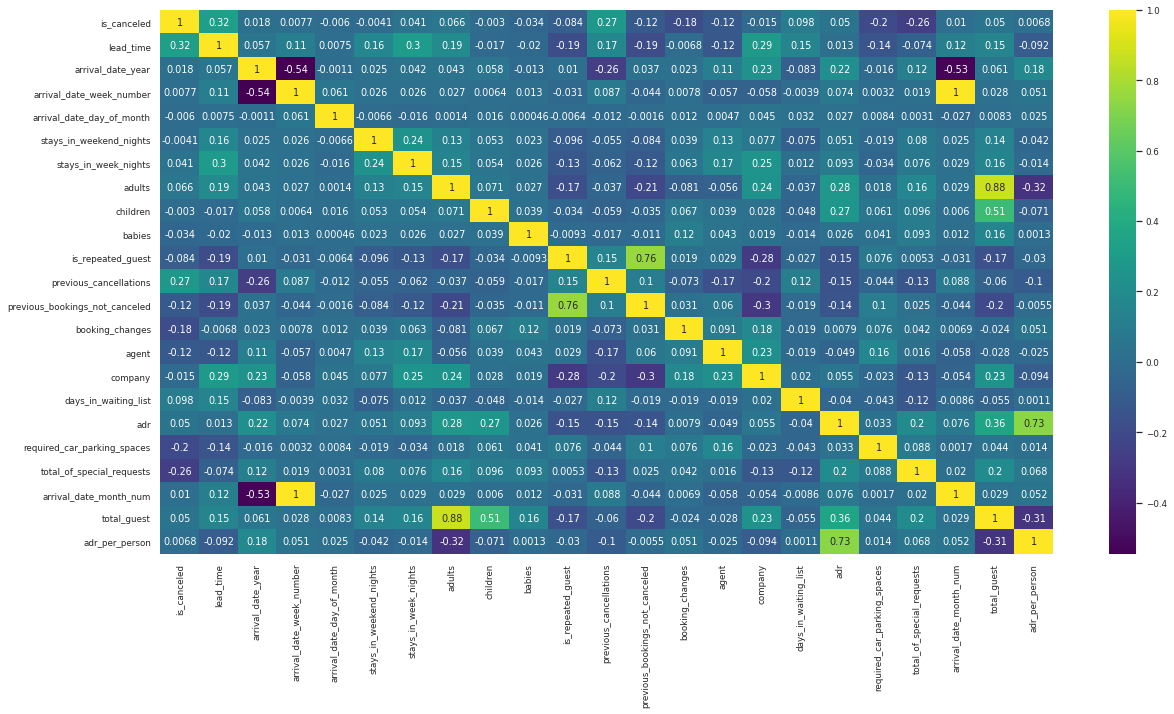

In [25]:
# Spearman Correlaton Heatmap
sns.heatmap(df.corr(method = 'spearman'), annot = True, cmap = "viridis")

In [26]:
# Before LabelEncoding
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_num,arrival_date,total_guest,adr_per_person
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,7,2015-07-01,2,0.00
75559,City Hotel,0,257,2015,July,27,1,0,2,1,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,No Deposit,6.0,NaN,0,Transient,80.0,0,0,Check-Out,2015-07-03,7,2015-07-01,1,80.00
75560,City Hotel,0,257,2015,July,27,1,0,2,2,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,101.5,0,0,Check-Out,2015-07-03,7,2015-07-01,2,50.75
75561,City Hotel,0,257,2015,July,27,1,0,2,2,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,101.5,0,0,Check-Out,2015-07-03,7,2015-07-01,2,50.75
75562,City Hotel,0,257,2015,July,27,1,0,2,2,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,NaN,0,Transient,101.5,0,0,Check-Out,2015-07-03,7,2015-07-01,2,50.75


## Preprocessing

In [27]:
# Unique Object values
a = df.select_dtypes(object).columns
for i in a:
    print (i, df[i].nunique())

hotel 2
arrival_date_month 12
meal 5
country 177
market_segment 8
distribution_channel 5
reserved_room_type 9
assigned_room_type 11
deposit_type 3
customer_type 4
reservation_status 3
reservation_status_date 926


In [28]:
# columns with dtype object
categorical_features = list(df.select_dtypes(include=['object']).columns)
categorical_features.remove('reservation_status_date')

# Label Encoder 
label_encoder_feat = {}
for i, feature in enumerate(categorical_features):
    df[feature] = df[feature].astype(str)
    label_encoder_feat[feature] = LabelEncoder()
    df[feature] = label_encoder_feat[feature].fit_transform(df[feature])

In [29]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_num,arrival_date,total_guest,adr_per_person
0,1,0,342,2015,5,27,1,0,0,2,0,0,0,135,3,1,0,0,0,2,2,3,0,NaN,NaN,0,2,0.0,0,0,1,2015-07-01,7,2015-07-01,2,0.00
75559,0,0,257,2015,5,27,1,0,2,1,0,0,2,135,5,3,0,0,0,0,0,1,0,6.0,NaN,0,2,80.0,0,0,1,2015-07-03,7,2015-07-01,1,80.00
75560,0,0,257,2015,5,27,1,0,2,2,0,0,2,135,5,3,0,0,0,0,0,0,0,6.0,NaN,0,2,101.5,0,0,1,2015-07-03,7,2015-07-01,2,50.75
75561,0,0,257,2015,5,27,1,0,2,2,0,0,2,135,5,3,0,0,0,0,0,0,0,6.0,NaN,0,2,101.5,0,0,1,2015-07-03,7,2015-07-01,2,50.75
75562,0,0,257,2015,5,27,1,0,2,2,0,0,2,135,5,3,0,0,0,0,0,0,0,6.0,NaN,0,2,101.5,0,0,1,2015-07-03,7,2015-07-01,2,50.75


In [30]:
df.shape

(119210, 36)

In [31]:
len(df1['country'].unique())

166

In [32]:
# Filling agent null values 
df.agent.fillna(0, inplace = True)
df.agent = df.agent.astype(int)

In [33]:
# Checking the correlation to choose the features to use in the Modelling
# Choosing the threshold Correlation as 0.04 (except for children)

df.corr(method = 'pearson')['is_canceled']

hotel                            -0.137082
is_canceled                       1.000000
lead_time                         0.292876
arrival_date_year                 0.016622
arrival_date_month               -0.001269
arrival_date_week_number          0.008315
arrival_date_day_of_month        -0.005948
stays_in_weekend_nights          -0.001323
stays_in_week_nights              0.025542
adults                            0.058182
children                          0.004851
babies                           -0.032569
meal                             -0.017227
country                           0.264695
market_segment                    0.059419
distribution_channel              0.167707
is_repeated_guest                -0.083745
previous_cancellations            0.110139
previous_bookings_not_canceled   -0.057365
reserved_room_type               -0.062216
assigned_room_type               -0.175843
booking_changes                  -0.144832
deposit_type                      0.468676
agent      

In [34]:
# The features that are going to be used for the training and testing

df_hotel = df[['hotel', 'lead_time', 'adults', 'children', 'babies', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest',
   'previous_cancellations', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
   'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled', 'adr', 'total_guest']].copy()

df_hotel.head()

,hotel,lead_time,adults,children,babies,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled,adr,total_guest
0,1,342,2,0,0,135,3,1,0,0,2,2,3,0,0,0,0,0,0,0.0,2
75559,0,257,1,0,0,135,5,3,0,0,0,0,1,0,6,0,0,0,0,80.0,1
75560,0,257,2,0,0,135,5,3,0,0,0,0,0,0,6,0,0,0,0,101.5,2
75561,0,257,2,0,0,135,5,3,0,0,0,0,0,0,6,0,0,0,0,101.5,2
75562,0,257,2,0,0,135,5,3,0,0,0,0,0,0,6,0,0,0,0,101.5,2


#### Cross Validation - StratifiedKFolds

In [35]:
df_hotel["kfold"] = -1

# shuffling
df_hotel = df_hotel.sample(frac = 1).reset_index(drop = True)

# targets
target = df_hotel.is_canceled.values

# stratified k fold with 5 folds
kf = model_selection.StratifiedKFold(n_splits = 5)

for i, (train, val) in enumerate(kf.split(X = df_hotel, y = target)):
    df_hotel.loc[val, 'kfold'] = i

In [36]:
df_hotel.kfold.unique()

array([0, 1, 2, 3, 4])

In [37]:
# This fuction will run 5 folds for each model and the performance can be seen during training.

def run(folds, model):

    # training and validation set
    df_train = df_hotel[df_hotel.kfold != folds].reset_index(drop = True)
    df_valid = df_hotel[df_hotel.kfold == folds].reset_index(drop = True)

    X_train = df_train.drop(columns = ['is_canceled']).values
    y_train = df_train.is_canceled.values

    X_valid = df_valid.drop(columns = ['is_canceled']).values
    y_valid = df_valid.is_canceled.values

    clf = models[model]

    print ("Training...")
    clf.fit(X_train, y_train)

    print ("Done!!")
    preds = clf.predict(X_valid)
        
    acc = metrics.accuracy_score(y_valid, preds)
    print ("Fold = {} Accuracy = {}".format(folds, acc))
    print ("------Classification Report")
    print (metrics.classification_report(y_valid, preds))

## Modelling

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Models Trained + DNN
models = {
    'logistic_regression' : LogisticRegression(C = 1.2),
    'xgboost': XGBClassifier(eta = 0.35, max_depth = 12),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest' :  RandomForestClassifier(n_estimators = 120),
    'knn': KNeighborsClassifier(n_neighbors=6,weights='distance')
    }

Decision Tree

In [39]:
# 5 folds
for fold in range(0,5):
  run(fold,'decision_tree')

Training...
Done!!
Fold = 0 Accuracy = 0.8377652881469675
------Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     15003
           1       0.78      0.78      0.78      8839

    accuracy                           0.84     23842
   macro avg       0.83      0.83      0.83     23842
weighted avg       0.84      0.84      0.84     23842

Training...
Done!!
Fold = 1 Accuracy = 0.8390235718479994
------Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     15002
           1       0.78      0.79      0.78      8840

    accuracy                           0.84     23842
   macro avg       0.83      0.83      0.83     23842
weighted avg       0.84      0.84      0.84     23842

Training...
Done!!
Fold = 2 Accuracy = 0.8416240248301317
------Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87

KNN Classifier

In [40]:
# 5 folds
for fold in range(0,5):
  run(fold,'knn')

Training...
Done!!
Fold = 0 Accuracy = 0.8139837261974666
------Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     15003
           1       0.76      0.73      0.74      8839

    accuracy                           0.81     23842
   macro avg       0.80      0.80      0.80     23842
weighted avg       0.81      0.81      0.81     23842

Training...
Done!!
Fold = 1 Accuracy = 0.8160808656991864
------Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     15002
           1       0.77      0.73      0.75      8840

    accuracy                           0.82     23842
   macro avg       0.80      0.80      0.80     23842
weighted avg       0.81      0.82      0.81     23842

Training...
Done!!
Fold = 2 Accuracy = 0.8090764197634427
------Classification Report
              precision    recall  f1-score   support

           0       0.84      0.86

#### Logistic Regression

In [41]:
# 5 Folds
for fold in range(0, 5):
    run(fold, 'logistic_regression')

Training...
Done!!
Fold = 0 Accuracy = 0.7547605066689036
------Classification Report
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     15003
           1       0.68      0.63      0.66      8839

    accuracy                           0.75     23842
   macro avg       0.74      0.73      0.73     23842
weighted avg       0.75      0.75      0.75     23842

Training...
Done!!
Fold = 1 Accuracy = 0.7614294102843722
------Classification Report
              precision    recall  f1-score   support

           0       0.78      0.86      0.82     15002
           1       0.72      0.59      0.65      8840

    accuracy                           0.76     23842
   macro avg       0.75      0.73      0.73     23842
weighted avg       0.76      0.76      0.76     23842

Training...
Done!!
Fold = 2 Accuracy = 0.7632748930458854
------Classification Report
              precision    recall  f1-score   support

           0       0.77      0.89

#### XGBoost

In [42]:
# 5 Folds
for fold in range(0, 5):
    model = run(fold, 'xgboost')

Training...
Done!!
Fold = 0 Accuracy = 0.8746330005871991
------Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15003
           1       0.86      0.79      0.82      8839

    accuracy                           0.87     23842
   macro avg       0.87      0.86      0.86     23842
weighted avg       0.87      0.87      0.87     23842

Training...
Done!!
Fold = 1 Accuracy = 0.8757235131280933
------Classification Report
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     15002
           1       0.86      0.80      0.83      8840

    accuracy                           0.88     23842
   macro avg       0.87      0.86      0.86     23842
weighted avg       0.87      0.88      0.87     23842

Training...
Done!!
Fold = 2 Accuracy = 0.8755137991779213
------Classification Report
              precision    recall  f1-score   support

           0       0.89      0.92

#### Random Forest

In [43]:
# 5 Folds
for fold in range(0, 5):
    run(fold, 'random_forest')

Training...
Done!!
Fold = 0 Accuracy = 0.871738948074826
------Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15003
           1       0.85      0.79      0.82      8839

    accuracy                           0.87     23842
   macro avg       0.87      0.85      0.86     23842
weighted avg       0.87      0.87      0.87     23842

Training...
Done!!
Fold = 1 Accuracy = 0.872703632245617
------Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15002
           1       0.86      0.79      0.82      8840

    accuracy                           0.87     23842
   macro avg       0.87      0.86      0.86     23842
weighted avg       0.87      0.87      0.87     23842

Training...
Done!!
Fold = 2 Accuracy = 0.8734166596762016
------Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92  

In [44]:
# Split the dataset into dependent and independent features
df_hotel = df[['hotel', 'lead_time', 'adults', 'children', 'babies', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest',
   'previous_cancellations', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
   'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled', 'adr', 'total_guest']].copy()

X=df_hotel.drop(['is_canceled'],axis=1)
y=df_hotel.is_canceled

In [45]:
# Other Approach for training the model
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [46]:
from sklearn.linear_model import LogisticRegression
model_logistic=LogisticRegression(C=1.5,random_state=1)
model_logistic.fit(X_train,y_train)

LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
# Predicting the model
y_pred_log=model_logistic.predict(X_test)
y_pred_log

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [48]:
# Find the accuracy and confusion matrix of the model
from sklearn.metrics import accuracy_score
print('The training accuracy of Logistic Regression is:',accuracy_score(y_train,model_logistic.predict(X_train)))
print('The testing accuracy of Logistic Regression is :',accuracy_score(y_pred_log,y_test))

The training accuracy of Logistic Regression is: 0.7708979951346363
The testing accuracy of Logistic Regression is : 0.7737186477644493


In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_logistic=confusion_matrix(y_test,y_pred_log)
print(confusion_logistic)
classification_logistic=classification_report(y_test,y_pred_log)
print(classification_logistic)

[[13757  1325]
 [ 4070  4690]]
              precision    recall  f1-score   support

           0       0.77      0.91      0.84     15082
           1       0.78      0.54      0.63      8760

    accuracy                           0.77     23842
   macro avg       0.78      0.72      0.74     23842
weighted avg       0.77      0.77      0.76     23842



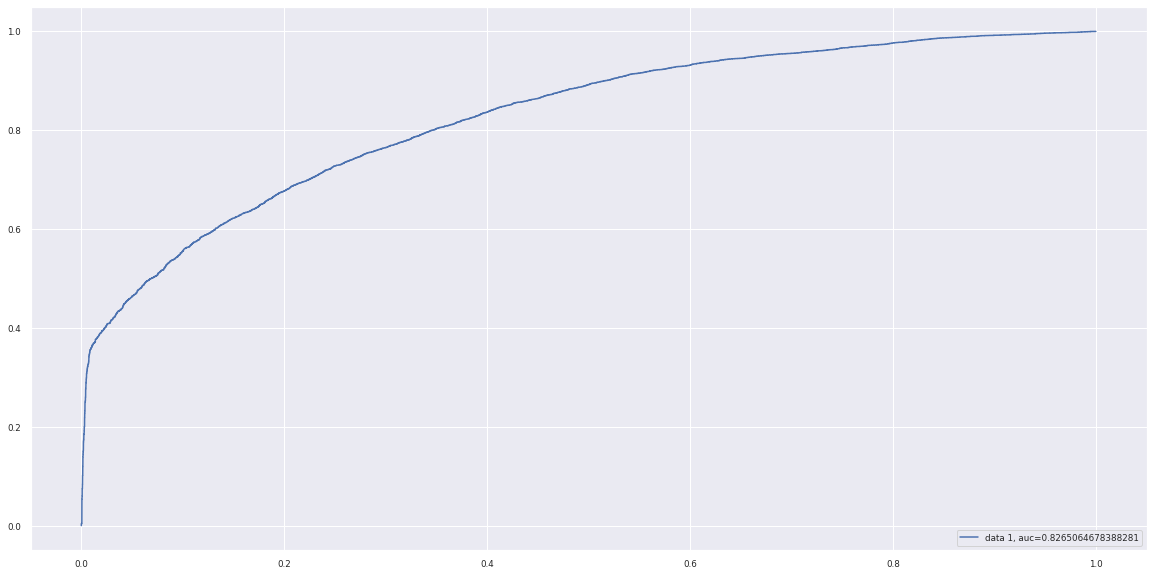

In [50]:
y_pred_proba = model_logistic.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [51]:
model_knn=KNeighborsClassifier()
model_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [52]:
# Predicting the model
y_pred_knn=model_knn.predict(X_test)
y_pred_knn

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [53]:
confusion_knn=confusion_matrix(y_test,y_pred_knn)
print(confusion_knn)
classification_knn=classification_report(y_test,y_pred_knn)
print(classification_knn)

[[12889  2193]
 [ 2571  6189]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     15082
           1       0.74      0.71      0.72      8760

    accuracy                           0.80     23842
   macro avg       0.79      0.78      0.78     23842
weighted avg       0.80      0.80      0.80     23842



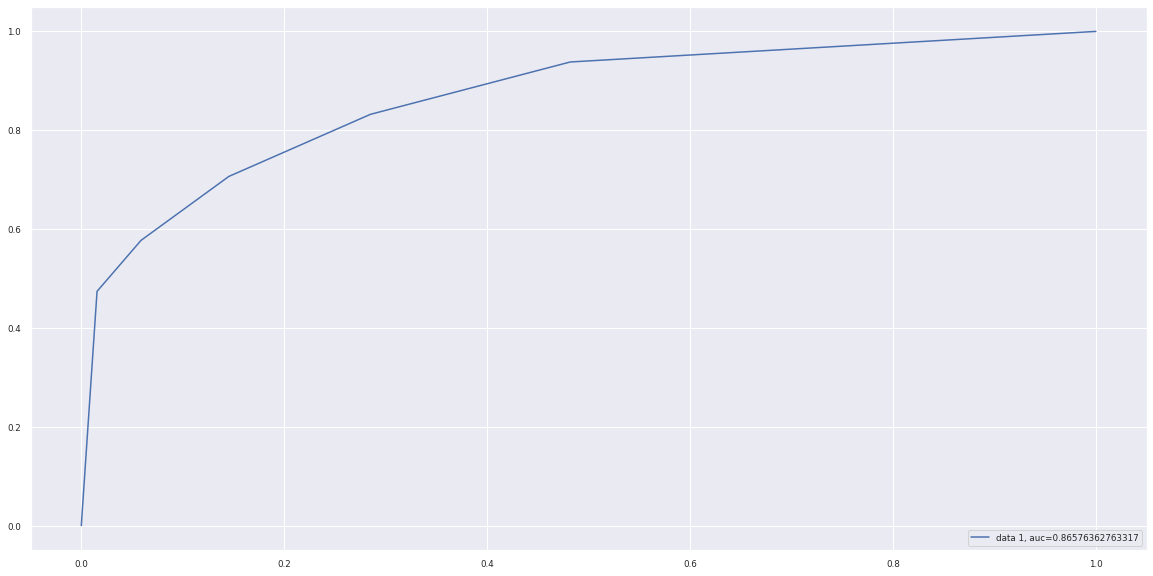

In [54]:
y_pred_proba_k = model_knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_k)
auc = metrics.roc_auc_score(y_test, y_pred_proba_k)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [55]:
model_dt=DecisionTreeClassifier()
model_dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [56]:
y_pred_dt=model_dt.predict(X_test)

In [57]:
confusion_dt=confusion_matrix(y_test,y_pred_dt)
print(confusion_dt)
classification_dt=classification_report(y_test,y_pred_dt)
print(classification_dt)

[[13252  1830]
 [ 1817  6943]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     15082
           1       0.79      0.79      0.79      8760

    accuracy                           0.85     23842
   macro avg       0.84      0.84      0.84     23842
weighted avg       0.85      0.85      0.85     23842



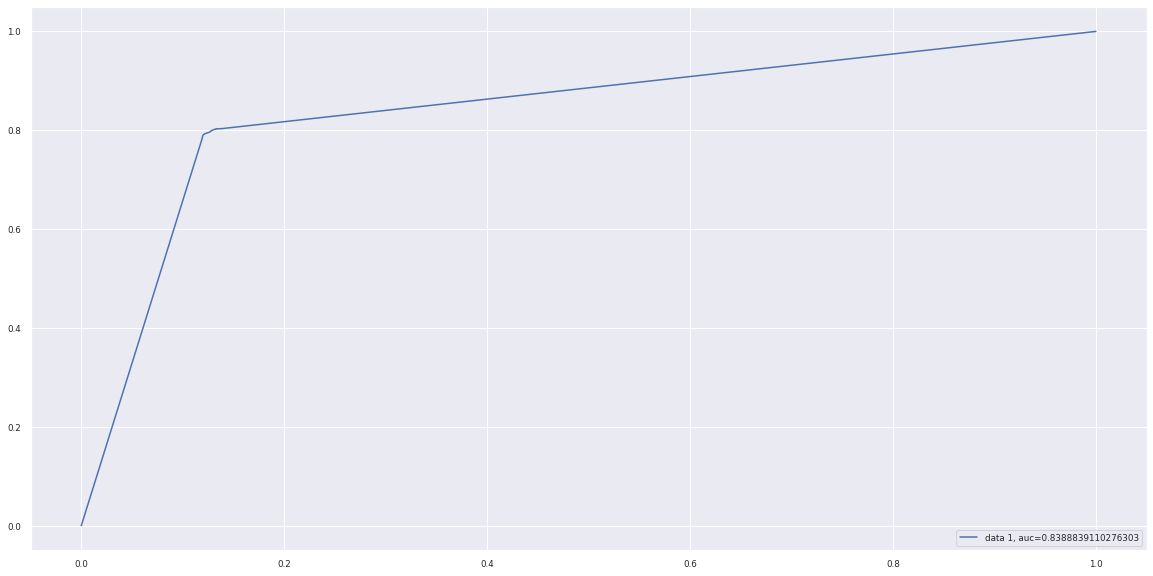

In [58]:
y_pred_proba_dt = model_dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_dt)
auc = metrics.roc_auc_score(y_test, y_pred_proba_dt)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [59]:
model_rf=RandomForestClassifier()
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [60]:
y_pred_rf=model_rf.predict(X_test)

In [61]:
confusion_rf=confusion_matrix(y_test,y_pred_rf)
print(confusion_rf)
classification_rf=classification_report(y_test,y_pred_rf)
print(classification_rf)

[[13878  1204]
 [ 1751  7009]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     15082
           1       0.85      0.80      0.83      8760

    accuracy                           0.88     23842
   macro avg       0.87      0.86      0.86     23842
weighted avg       0.88      0.88      0.88     23842



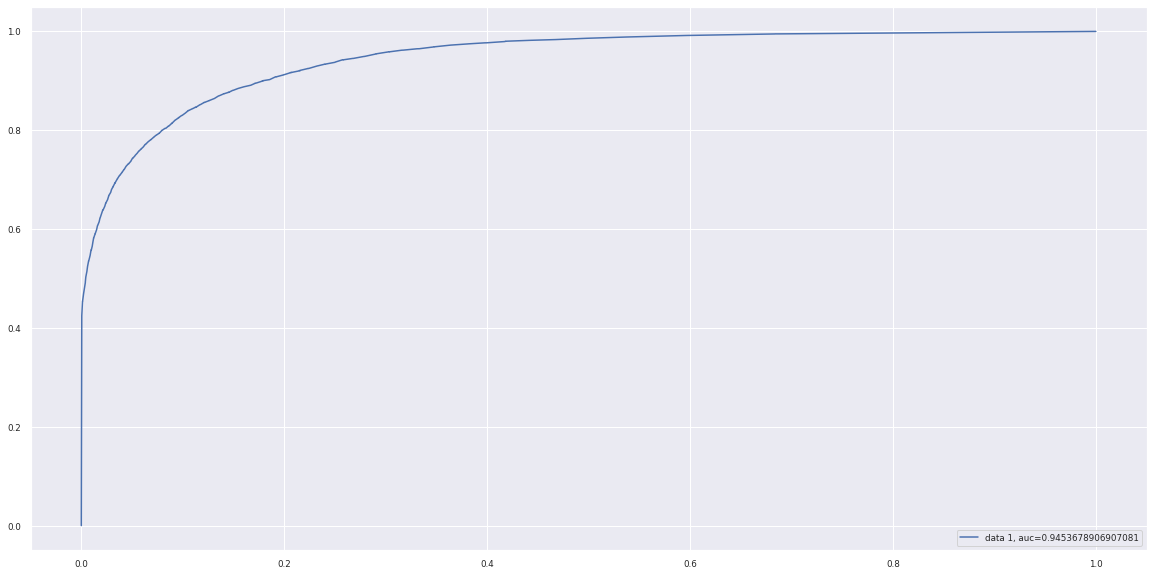

In [62]:
y_pred_proba_rf = model_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rf)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [63]:
# Post Pruning with Decision Trees
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

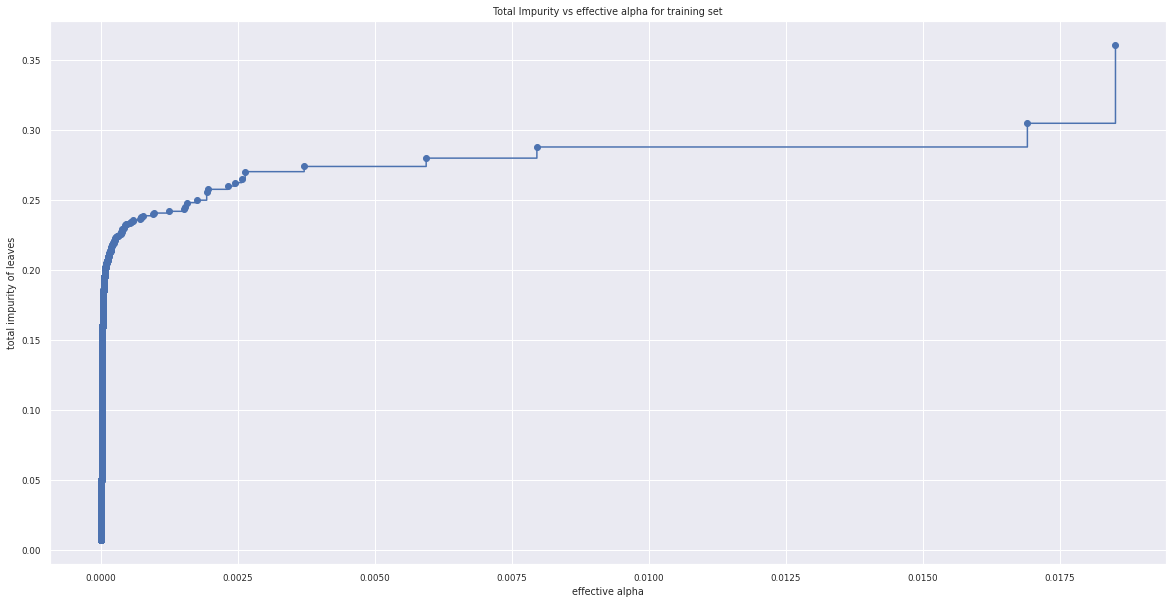

In [64]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [67]:
#clfs = []
#for ccp_alpha in ccp_alphas:
#    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
#    clf.fit(X_train, y_train)
#    clfs.append(clf)
#print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#      clfs[-1].tree_.node_count, ccp_alphas[-1]))

In [69]:
#clfs = clfs[:-1]
#ccp_alphas = ccp_alphas[:-1]

#node_counts = [clf.tree_.node_count for clf in clfs]
#depth = [clf.tree_.max_depth for clf in clfs]
#fig, ax = plt.subplots(2, 1)
#ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
#ax[0].set_xlabel("alpha")
#ax[0].set_ylabel("number of nodes")
#ax[0].set_title("Number of nodes vs alpha")
#ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
#ax[1].set_xlabel("alpha")
#ax[1].set_ylabel("depth of tree")
#ax[1].set_title("Depth vs alpha")
#fig.tight_layout()